In [1]:
using CSV, DataFrames, Statistics
using Plots, StatsPlots
using ColorSchemes, Measures

function se(x)
    std(x)/sqrt(length(x))
end

se (generic function with 1 method)

In [2]:
df = similar(CSV.read("aistats-rev/synthetic/"*"linear_mar/"*"FINAL_results.csv", DataFrame),0)
for dir = ["linear_mar/", "linear_censoring/", "nn_mar/", "nn_censoring/"]
    directory = "aistats-rev/"*"synthetic/"*dir
    df = vcat(df, CSV.read(directory*"FINAL_results.csv", DataFrame)[:,names(df)])
end

#### Formatting Fixing

In [3]:
df[!,:n] .= map(t -> parse(Int,split(t,"_")[2]), df[:,:dataset]) ;
df[isnan.(df[:,:r2]),:r2] .= 0.
df[isnan.(df[:,:osr2]),:osr2] .= 0.

filter!(t -> t[:pMissing] <= 0.8, df)
filter!(t -> t[:n] > 20, df) ;

# df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 4" => "Mean Impute-then-Regress"), df[:,:method])
# df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 2" => "mice Impute-then-Regress"), df[:,:method])
# df[!,:method] .= map(t -> replace(t, "Joint Imp-then-Reg" => "Joint Impute-then-Regress"), df[:,:method])
# df[!,:method] .= map(t -> replace(t, "Static" => "Adaptive LR - Affine intercept"), df[:,:method]) ;

Row,dataset,SNR,k,pMissing,splitnum,method,r2,osr2,r2list,osr2list,muvec,time,hp,score,method_cat,X_setting,Y_setting,n
,String15,Int64,Int64,Float64,Int64,String31,Float64,Float64,String,String,String,Float64,String,Float64,String31,String15,String15,Int64
1,n_1000_p_10,2,5,0.1,1,XGBoost,0.867763,0.665557,"Any[0.8670880147422774, 0.8741652959398137, 0.9079461560636061, 0.8301653996873348, 0.9357979292111781, 0.8074834330936, 0.8679696943229437, 0.882208722845547, 0.862601239817399, 0.7901688685115005, 0.9060421274045598, 0.34144479363700575, 0.22846090338152314, 0.9626097970063168, 0.5961386307149869, 0.8413697547852105, 0.9069043604653245, 0.6235000317865542, 0.958102587028391, 0.608105394100185, 0.7070161506530841, 0.7635508941027063, 0.8140969548850339, 0.9894081414338083, 0.7742166285730437, 0.805805505452694, 0.5385225219452628, 0.7033380650929189, 0.891553736875657, 0.8110705538226934, 0.7126647844183887, 0.05135941522725518, 0.7782647290497838, -0.44611022897910013, 0.6390217872750555, 0.8595023987943273, 0.7720950490093842, 0.7785703904529087, 0.8872086813267762, 0.7559930968527795, 0.7391809518187746, -Inf, 0.7578071699265996, 0.5731517800169293, 0.9311936225795421, 0.69554742778856, 0.6726991354306974, 0.9471835143466918, 0.8172422878863244, 0.8808108817940847, 0.8982960899761009, -3.097435487172808, 0.759737971760359, 0.9013207568307327, 0.9703131999550991, -Inf, 0.8366041724772559, -Inf, -4.207952540686617, 0.5987014667995144, -Inf, -Inf, -Inf, -Inf, -Inf, 0.8812771668941323, -Inf, -Inf, -Inf, 0.45622498523821897, -Inf, -Inf, -Inf, -Inf, 0.272040096534126, -Inf, -Inf, 0.052168891342215806, 0.8632013624478727, -Inf, -Inf, -3.572845490149887, -Inf, -Inf, -Inf, -Inf, 0.9454301001015206, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -Inf, -11.37004596473381, -Inf, 0.8527231212974538]","Any[0.6901022632979699, 0.7582530110690645, 0.7578907468604466, 0.7302011207066357, 0.7153988234783741, 0.6901903546684793, 0.6265871698504313, 0.6754314034951756, 0.7383453211081885, 0.48709669993313465, 0.69631393645832, 0.6229592137678541, 0.2165279249300689, 0.664065066642009, 0.6256456148517517, 0.7135100936445387, 0.911911502011368, 0.5723580348675505, 0.6862811713744261, 0.8859761318175525, 0.6880656698339617, 0.8008884217336599, 0.8273805351318478, 0.770865184043202, 0.7738742403618328, 0.5615292616430259, 0.526827104130964, 0.7555855063553801, 0.7107923231513097, 0.3777249497422769, 0.14796670695172043, 0.7929211329061656, 0.8905931628457238, 0.6810278424232001, 0.6067443464591418, 0.8724405444144466, 0.8338286190858484, 0.6967972265736014, 0.49896795199759514, 0.6166211286816126, 0.8766449474037058, 0.8150215283644264, 0.6816726450301132, 0.5245547899733656, 0.5244221677441013, 0.41774369740547923, 0.7770853177159475, 0.5907298119233896, 0.6092639823624639, 0.7694888801605578, 0.7366319430693117, 0.8011410671715307, 0.6157525261981169, 0.5110068884073233, 0.8292340919719074, 0.6157832592524478, 0.6431444414185286, 0.9271985486344526, -0.11880672688829774, 0.4074621663939749, 0.8444486628257372, 0.6255334026546728, 0.9663987234602667, 0.9474509877289716, -0.7394780535869541, 0.7946105494891792, -0.9080956864283238, 0.9696755132897166, 0.9273130200131017, 0.9801614170746121, 0.9772505364289308, 0.9671675298988358, 0.7082887136063901, 0.9281260777510287, NaN, 0.979062258645375, -0.23443109146657637, -46.79711331206637, 0.8451274910809863, 0.8778165791475974, 0.8970912658134563, -254.47926236677716, 0.6830137832757717, 0.8915930057960226, 0.9714212059488746, 0.9617020265452374, NaN, -1.5464466733021887, -0.7108943496382747, 0.7211417822484346, 0.6464183779490773, 0.6102602927430191, 0.9921794789006966, 0.9941082682130212, NaN, -6.102687219294461, 0.6101770047635877]",Any[],203.478,"Dict{Symbol, Real}(:min_child_weight => 5, :gamma => 0.0, :n_estimators => 50, :max_depth => 5)",0.679394,XGBoost,syn_X_mar,syn_Y_linear,1000
2,n_1000_p_10,2,5,0.1,1,Oracle X,0.777155,0.772589,"Any[0.7624418968609468, 0.7765633288096581, 0.8137549561707175, 0.805

#### Rename methods and generate the ``best'' variants

In [4]:
#Rename methods
df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 4" => "Mean Impute-then-Regress"), df[:,:method])
df[!,:method] .= map(t -> replace(t, "Imp-then-Reg 2" => "mice Impute-then-Regress"), df[:,:method])

df[!,:method] .= map(t -> replace(t, "Joint Imp-then-Reg" => "Joint Impute-then-Regress"), df[:,:method])

df[!,:method] .= map(t -> replace(t, "Affine" => "Adaptive LR - Affine"), df[:,:method]) ;
df[!,:method] .= map(t -> replace(t, "Finite" => "Adaptive LR - Finite"), df[:,:method]) ;
df[!,:method] .= map(t -> replace(t, "Static" => "Adaptive LR - Affine intercept only"), df[:,:method]) ;

In [5]:
for method in ["Adaptive LR"]
    aux = filter(t -> startswith(t[:method], method), df)
    # @show size(aux)
    idcols = [:dataset, :X_setting, :Y_setting, :n, :SNR, :k, :pMissing, :splitnum]
    gd = groupby(aux, idcols)

    aux = similar(aux, 0)
    for subdf in gd 
        scoremax = argmax(subdf[:,:score])
        push!(aux, subdf[scoremax,names(aux)])
    end
    aux[!,:method] .= method*" - best"

    df = vcat(df, aux)
end

## Section 3: Evaluation of joint impute-then-regress strategies

#### Figure 1: Plot R2 vs pMissing, linear Y, adaptive LR vs. heuristic for joint

Linear Y

In [30]:
pal = ColorSchemes.Egypt

In [31]:
df_lin = filter(t-> t[:Y_setting] == "syn_Y_linear", df)
filter!(t -> t[:method] ∈ [
        "Adaptive LR - Affine intercept only", 
        "Joint Impute-then-Regress - best", 
        "Mean Impute-then-Regress - best", 
        "RF MIA"], df_lin)


gd = groupby(df_lin, [:pMissing, :method, :X_setting])
stats = combine(gd, :osr2 .=> [mean, se]) ;

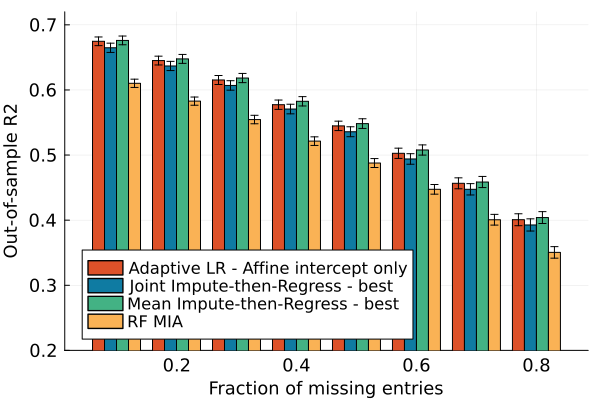

In [32]:
@df filter(t -> t[:X_setting] == "syn_X_mar", stats) groupedbar(:pMissing, :osr2_mean, 
    yerr=:osr2_se, group=:method, legend=:bottomleft, 
    guidefontsize=12, tickfontsize=12, legendfontsize=11,
    palette = pal)
xaxis!("Fraction of missing entries")
yaxis!("Out-of-sample R2", ylims=(0.2,0.72))

In [33]:
mkpath("../figures/adaptive_regression/validation")
Plots.savefig("../figures/adaptive_regression/validation/synthetic_linearY_mar.pdf")

"/Users/jeanpauphilet/Dropbox/Work/1 - Research/PHD/figures/adaptive_regression/validation/synthetic_linearY_mar.pdf"

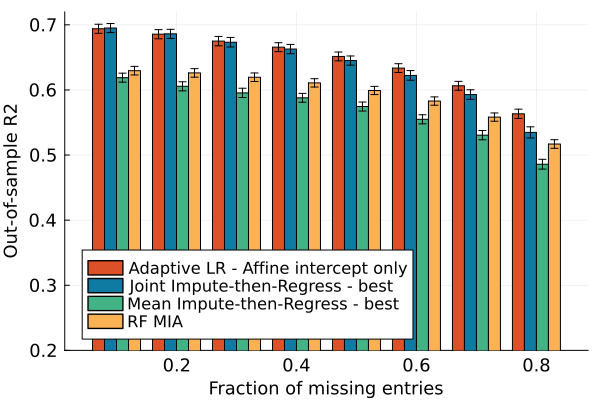

In [34]:
@df filter(t -> t[:X_setting] == "syn_X_censoring", stats) groupedbar(:pMissing, :osr2_mean, 
    yerr=:osr2_se, group=:method, legend=:bottomleft, 
    guidefontsize=12, tickfontsize=12, legendfontsize=11,
    color_palette = pal)
xaxis!("Fraction of missing entries")
yaxis!("Out-of-sample R2", ylims=(0.2,0.72))

In [35]:
Plots.savefig("../figures/adaptive_regression/validation/synthetic_linearY_censoring.pdf")

"/Users/jeanpauphilet/Dropbox/Work/1 - Research/PHD/figures/adaptive_regression/validation/synthetic_linearY_censoring.pdf"

NN Y

In [46]:
df_nn = filter(t-> t[:Y_setting] == "syn_Y_nn", df)
filter!(t -> t[:method] ∈ [ 
        # "Adaptive LR - Affine intercept only", 
        "Adaptive LR - best", 
        "Joint Impute-then-Regress - best", 
        "Mean Impute-then-Regress - best",
        "RF MIA"], df_nn)

gd = groupby(df_nn, [:pMissing, :method, :X_setting])
stats = combine(gd, :osr2 .=> [mean, se])

Row,pMissing,method,X_setting,osr2_mean,osr2_se
,Float64,String,String15,Float64,Float64
1,0.1,RF MIA,syn_X_mar,0.542588,0.00747814
2,0.2,RF MIA,syn_X_mar,0.512117,0.00735406
3,0.3,RF MIA,syn_X_mar,0.476086,0.00734732
4,0.4,RF MIA,syn_X_mar,0.437179,0.00719691
5,0.5,RF MIA,syn_X_mar,0.395027,0.0071149
6,0.6,RF MIA,syn_X_mar,0.343323,0.00719899
7,0.7,RF MIA,syn_X_mar,0.2881,0.00717477
8,0.8,RF MIA,syn_X_mar,0.227629,0.0072703
9,0.1,Mean Impute-then-Regress - best,syn_X_mar,0.539999,0.0076531


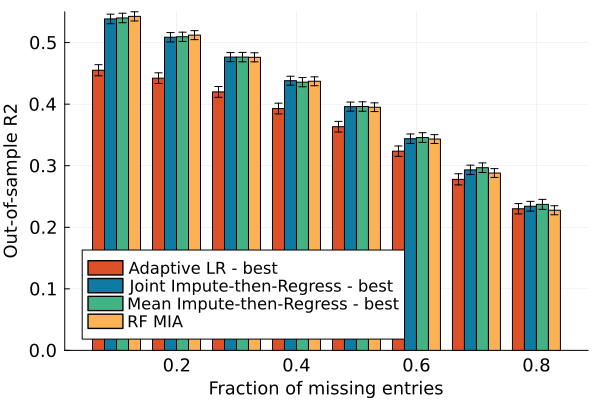

In [47]:
@df filter(t -> t[:X_setting] == "syn_X_mar", stats) groupedbar(:pMissing, :osr2_mean, 
    yerr=:osr2_se, group=:method, legend=:bottomleft,
    guidefontsize=12, tickfontsize=12, legendfontsize=11,
    # color_palette = pal)
    color = [pal[2] pal[3] pal[4]])
xaxis!("Fraction of missing entries")
yaxis!("Out-of-sample R2", ylims=(0,0.55))

In [38]:
Plots.savefig("../figures/adaptive_regression/validation/synthetic_nnY_mar.pdf")

"/Users/jeanpauphilet/Dropbox/Work/1 - Research/PHD/figures/adaptive_regression/validation/synthetic_nnY_mar.pdf"

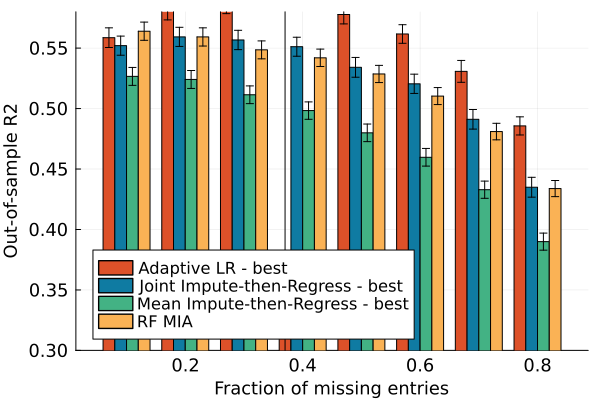

In [48]:
@df filter(t -> t[:X_setting] == "syn_X_censoring", stats) groupedbar(:pMissing, :osr2_mean, yerr=:osr2_se, 
    group=:method, legend=:bottomleft, 
    guidefontsize=12, tickfontsize=12, legendfontsize=11,
    # color_palette = pal)
    color = [pal[2] pal[3] pal[4]])
xaxis!("Fraction of missing entries")
yaxis!("Out-of-sample R2", ylims=(0.3,0.58))

In [40]:
Plots.savefig("../figures/adaptive_regression/validation/synthetic_nnY_censoring.pdf")

"/Users/jeanpauphilet/Dropbox/Work/1 - Research/PHD/figures/adaptive_regression/validation/synthetic_nnY_censoring.pdf"

#### Output 2: Summary Table

In [47]:
subdf = filter(t -> t[:method] ∈ [ "Adaptive LR - best", 
        "CART MIA", 
        "RF MIA",
        "XGBoost",
        "Joint Impute-then-Regress - best", 
        "Mean Impute-then-Regress - best", 
        "mice Impute-then-Regress - best"], 
    df)

filter!(t -> t[:pMissing] < 0.9, subdf)
filter!(t -> t[:n] <= 1000, subdf)

gd = groupby(subdf, [:X_setting, :Y_setting, :method])
stats = combine(gd, :osr2 .=> [mean, se])

Row,X_setting,Y_setting,method,osr2_mean,osr2_se
,String15,String15,String,Float64,Float64
1,syn_X_mar,syn_Y_linear,XGBoost,0.479729,0.00309715
2,syn_X_mar,syn_Y_linear,CART MIA,0.327419,0.00328755
3,syn_X_mar,syn_Y_linear,RF MIA,0.494468,0.00287625
4,syn_X_mar,syn_Y_linear,mice Impute-then-Regress - best,0.561293,0.0035525
5,syn_X_mar,syn_Y_linear,Mean Impute-then-Regress - best,0.555383,0.0030471
6,syn_X_mar,syn_Y_linear,Joint Impute-then-Regress - best,0.543611,0.00311841
7,syn_X_censoring,syn_Y_linear,XGBoost,0.585526,0.00258764
8,syn_X_censoring,syn_Y_linear,CART MIA,0.459456,0.00287801
9,syn_X_censoring,syn_Y_linear,RF MIA,0.592943,0.00235682


In [48]:
s = ""
for m in sort(unique(stats[:,:method]))
    aux = filter(t->t[:method]==m, stats)
    s *= m*" & "
    for x in ["syn_X_mar", "syn_X_censoring"]
        for y in "syn_Y_".*["linear", "nn"]
            r1 = filter(t -> t[:Y_setting] == y && t[:X_setting] == x, aux)[1,:osr2_mean]
            s *= string(round(r1, digits=3))
            r1 = filter(t -> t[:Y_setting] == y && t[:X_setting] == x, aux)[1,:osr2_se]
            s *= string(" (",round(r1, digits=3), ") & ")
        end
    end
    s *= " \\\\ \n"
end
print(s)

Adaptive LR - best & 0.562 (0.003) & 0.363 (0.003) & 0.646 (0.003) & 0.531 (0.027) &  \\ 
CART MIA & 0.327 (0.003) & 0.227 (0.003) & 0.459 (0.003) & 0.368 (0.003) &  \\ 
Joint Impute-then-Regress - best & 0.544 (0.003) & 0.404 (0.003) & 0.639 (0.003) & 0.525 (0.003) &  \\ 
Mean Impute-then-Regress - best & 0.555 (0.003) & 0.405 (0.003) & 0.569 (0.003) & 0.478 (0.003) &  \\ 
RF MIA & 0.494 (0.003) & 0.403 (0.003) & 0.593 (0.002) & 0.521 (0.003) &  \\ 
XGBoost & 0.48 (0.003) & 0.375 (0.003) & 0.586 (0.003) & 0.502 (0.003) &  \\ 
mice Impute-then-Regress - best & 0.561 (0.004) & 0.43 (0.004) & 0.464 (0.004) & 0.348 (0.004) &  \\ 


In [ ]:
sort(unique(subdf[:,:n]))